In [1]:
!python --version
!pip install pandas

Python 3.7.7


In [1]:
#https://stackoverflow.com/questions/53457975/pyspark-udf-function-error-in-lambda-function
import os

os.environ['OBJC_DISABLE_INITIALIZE_FORK_SAFETY'] = 'YES'

In [2]:
from pyspark.sql import SparkSession
# https://spark.apache.org/docs/latest/job-scheduling.html
spark = SparkSession.\
        builder.\
        appName("pyspark-notebook2-dave").\
        master("spark://spark-master:7077").\
        config("spark.executor.memory", "7g").\
        config("spark.cores.max", "3").\
        config("spark.executor.instances", "1").\
        config("spark.executor.cores", "3").\
        config("spark.mongodb.input.uri","mongodb://mongo1:27017,mongo2:27018,mongo3:27019/database.horses_collection?replicaSet=rs0").\
        config("spark.mongodb.output.uri","mongodb://mongo1:27017,mongo2:27018,mongo3:27019/database.horses_collection?replicaSet=rs0").\
        config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:3.0.0").\
        getOrCreate()

Ivy Default Cache set to: /home/jovyan/.ivy2/cache
The jars for the packages stored in: /home/jovyan/.ivy2/jars
:: loading settings :: url = jar:file:/usr/local/spark-3.0.0-bin-hadoop3.2/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml
org.mongodb.spark#mongo-spark-connector_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-13795a17-2aba-481d-a900-63ff179faba7;1.0
	confs: [default]
	found org.mongodb.spark#mongo-spark-connector_2.12;3.0.0 in central
	found org.mongodb#mongodb-driver-sync;4.0.5 in central
	found org.mongodb#bson;4.0.5 in central
	found org.mongodb#mongodb-driver-core;4.0.5 in central
:: resolution report :: resolve 328ms :: artifacts dl 15ms
	:: modules in use:
	org.mongodb#bson;4.0.5 from central in [default]
	org.mongodb#mongodb-driver-core;4.0.5 from central in [default]
	org.mongodb#mongodb-driver-sync;4.0.5 from central in [default]
	org.mongodb.spark#mongo-spark-connector_2.12;3.0.0 from central in [defaul

In [3]:
spark.catalog.currentDatabase()

'default'

In [4]:
# reading dataframes from MongoDB
# sampleSize - https://stackoverflow.com/a/56255303
df = spark.read.format("mongo").option('sampleSize', 50000).load()
df.createOrReplaceTempView("mongo")

21/12/22 22:42:59 WARN MongoInferSchema: Field 'bsp' contains conflicting types converting to StringType
21/12/22 22:43:01 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [5]:
df.printSchema()

root
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- clk: string (nullable = true)
 |-- mc: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- id: string (nullable = true)
 |    |    |-- marketDefinition: struct (nullable = true)
 |    |    |    |-- betDelay: integer (nullable = true)
 |    |    |    |-- bettingType: string (nullable = true)
 |    |    |    |-- bspMarket: boolean (nullable = true)
 |    |    |    |-- bspReconciled: boolean (nullable = true)
 |    |    |    |-- complete: boolean (nullable = true)
 |    |    |    |-- countryCode: string (nullable = true)
 |    |    |    |-- crossMatching: boolean (nullable = true)
 |    |    |    |-- discountAllowed: boolean (nullable = true)
 |    |    |    |-- eachWayDivisor: double (nullable = true)
 |    |    |    |-- eventId: string (nullable = true)
 |    |    |    |-- eventName: string (nullable = true)
 |    |    |    |-- eventTypeId: string (nullable = true)
 | 

In [6]:
# spark.sql("select * from mongo array_contains(root.mc, array('CLOSED'))").show()
from pyspark.sql.functions import *  

In [7]:
mc_exploded = df.select('*', explode(df.mc).alias('mc_row'))

In [8]:
md_only = mc_exploded.filter(mc_exploded.mc_row.marketDefinition.isNotNull())

In [9]:
#md_only.show()

In [10]:
# Explode the marketDefinition array.
market_definitions = md_only.selectExpr('op AS operation_type',
                                        'clk AS sequence_token',
                                        'pt AS published_time',
                                        'mc_row.id AS market_id',
                                        'mc_row.rc AS rc',
                                        'mc_row.marketDefinition.betDelay AS bet_delay',
                                        'mc_row.marketDefinition.bettingType AS betting_type',
                                        'mc_row.marketDefinition.bspMarket AS bsp_market',
                                        'mc_row.marketDefinition.bspReconciled AS bsp_reconciled',
                                        'mc_row.marketDefinition.complete AS complete',
                                        'mc_row.marketDefinition.countryCode AS country_code',
                                        'mc_row.marketDefinition.crossMatching AS cross_matching',
                                        'mc_row.marketDefinition.discountAllowed AS discount_allowed',
                                        'mc_row.marketDefinition.eventId AS event_id',
                                        'mc_row.marketDefinition.eventName AS event_name',
                                        'mc_row.marketDefinition.eventTypeId AS event_type_id',
                                        'mc_row.marketDefinition.inPlay AS in_play',
                                        'mc_row.marketDefinition.marketBaseRate AS market_base_rate',
                                        'mc_row.marketDefinition.marketTime AS market_time',
                                        'mc_row.marketDefinition.marketType AS market_type',
                                        'mc_row.marketDefinition.numberOfActiveRunners AS number_of_active_runners',
                                        'mc_row.marketDefinition.numberOfWinners AS number_of_winners',
                                        'mc_row.marketDefinition.openDate AS open_date',
                                        'mc_row.marketDefinition.persistenceEnabled AS persistence_enabled',
                                        'mc_row.marketDefinition.runnersVoidable AS runners_voidable',
                                        'mc_row.marketDefinition.settledTime AS settled_time',
                                        'mc_row.marketDefinition.status AS status',
                                        'mc_row.marketDefinition.suspendTime AS suspend_time',
                                        'mc_row.marketDefinition.timezone AS timezone',
                                        'mc_row.marketDefinition.turnInPlayEnabled AS turn_in_play_enabled',
                                        'mc_row.marketDefinition.version AS version',
                                        'mc_row.marketDefinition.name AS market_name',
                                        'mc_row.marketDefinition.regulators AS regulators',
                                        'mc_row.marketDefinition.runners AS runners')

In [11]:
market_definitions1 = market_definitions.filter(market_definitions["status"]=="CLOSED")

In [12]:
market_definitions1 = market_definitions1.filter(market_definitions["market_type"]=="WIN")

In [13]:
runners_only = market_definitions1.filter(market_definitions.runners.isNotNull())

In [14]:
# Explode the Runners array.
runners_exploded = runners_only.select(market_definitions1.operation_type,
                                       market_definitions1.published_time,
                                       market_definitions1.market_id,
                                       market_definitions1.market_name,
                                       market_definitions1.event_id,
                                       market_definitions1.event_name,
                                       explode(market_definitions1.runners).alias('runner_row'))

In [15]:
##### new dataset (just added BSP to the runners dataframe created above)
runners_exploded_wbsp = runners_only.select(market_definitions1.operation_type,
                                       market_definitions1.published_time,
                                       market_definitions1.market_id,
                                       market_definitions1.market_name,
                                       market_definitions1.event_id,
                                       market_definitions1.event_name,
                                       explode(market_definitions1.runners).alias('runner_row'))

In [16]:
##### new dataset (just added BSP to the runners dataframe created above)
runners_wbsp = runners_exploded_wbsp.selectExpr('operation_type',
                                      'published_time',
                                      'market_id',
                                      'market_name',
                                      'event_id',
                                      'event_name',
                                      'runner_row.id AS runner_id',
                                      'runner_row.name AS runner_name',
                                      'runner_row.status AS runner_status',
                                      'runner_row.bsp AS bsp',
                                      'runner_row.sortPriority AS runner_sort_priority')

In [17]:
# filter dataframe where horses status is not removed, removed_vacant
runners_wbsp = runners_wbsp.filter(runners_wbsp.runner_status!='REMOVED')

In [18]:
runners_wbsp = runners_wbsp.filter(runners_wbsp.runner_status!='REMOVED_VACANT')

In [19]:
# filter dataframe where bsp is not none or NaN
runners_wbsp = runners_wbsp.filter(runners_wbsp.bsp!='None')

In [20]:
runners_wbsp = runners_wbsp.filter(runners_wbsp.bsp!='NaN')

In [21]:
# drop duplicates
runners_wbsp = runners_wbsp.dropDuplicates()

In [22]:
# filter bsp must be greater than 1
runners_wbsp = runners_wbsp.filter(runners_wbsp.bsp>1)

In [23]:
#### Non_arbitrary finding 3: What were the best performing horses in 2016 in terms of betting returns?  
### Chart cumulative returns by races won 

In [24]:
# bsp is returns if you bet €1
# create returns column that is bsp if the horse is a winner, otherwise -1
# create wins column which is 1 if horse wins, 0 otherwise
# create losses column which is 1 if horse loses, 0 otherwise
runners_returns = runners_wbsp \
        .withColumn("returns", when(col("runner_status") == "WINNER", col("bsp") * 1).otherwise(-1)) \
        .withColumn("wins", when(col("runner_status") == "WINNER", 1).otherwise(0)) \
        .withColumn("losses", when(col("runner_status") == "LOSER", 1).otherwise(0)) 

In [25]:
#runners_returns.show()

In [26]:
# remove leading numbers and full stop from runner_name column
runners_returns = runners_returns.withColumn('runner_name', 
                                             regexp_replace('runner_name', r'(^[\d\.]+)', ''))

In [27]:
import pandas

In [28]:
# groupby runner name
# sum returns, wins & losses
runners_returns_agg = runners_returns \
        .groupBy("runner_name") \
        .agg(sum("returns").alias("total_returns"), 
             sum("wins").alias("total_wins"), 
             sum("losses").alias("total_losses"))

In [29]:
# add total races column which is sum of total_wins and total_losses
runners_returns_agg = runners_returns_agg \
        .withColumn("total_races", col("total_wins") + col("total_losses"))

In [30]:
# sort df descending by returns to get horses with top betting returns
runners_returns_agg = runners_returns_agg.sort(runners_returns_agg.total_returns.desc())

In [31]:
# get top 10 horses by returns
top_10 = runners_returns_agg.limit(10)

In [32]:
pdf_10 = top_10.toPandas()

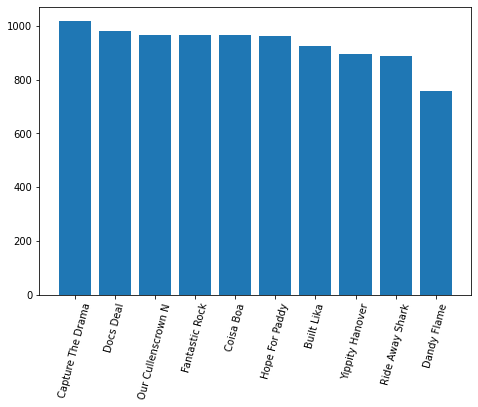

In [33]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(pdf_10.runner_name, pdf_10.total_returns)
plt.xticks(rotation=75)
plt.show()

In [34]:
# get top 10000 horses by winnings
top_10000 = runners_returns_agg.limit(10000)

In [35]:
# groupby total_wins and sum total_returns
# cumulative returns 
top_10000_aggregated = top_10000  \
        .groupBy("total_wins") \
        .agg(sum("total_returns").alias("total_returns"), 
             sum("total_wins").alias("summed_wins"))

In [36]:
top_10000_aggregated.show()

+----------+------------------+-----------+
|total_wins|     total_returns|summed_wins|
+----------+------------------+-----------+
|         5| 4557.290000000001|        550|
|         4|13371.019999999995|       1776|
|         1| 139902.8299999996|       4998|
|         2| 72810.82999999997|       6022|
|         3| 34081.34000000007|       4206|
|         6|1478.9999999999998|        174|
|         7|            156.38|         42|
+----------+------------------+-----------+



In [37]:
pdf_top_10000 = top_10000_aggregated.toPandas()

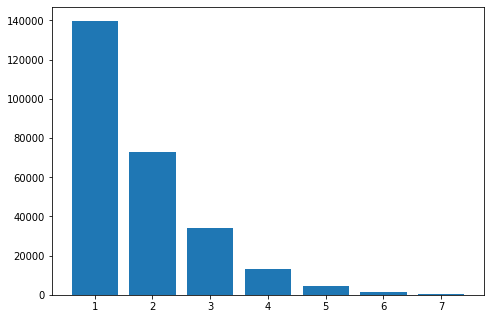

In [38]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(pdf_top_10000.total_wins, pdf_top_10000.total_returns)
plt.show()

In [ ]:
# connector is called 'mysql-connector-python'
# Google it and what you want to do
import mysql.connector

mydb = mysql.connector.connect(
  host="mysql",
  user="ssbd",
  password="pass",
  database='analysis_db'
)

print(mydb)

In [ ]:
# https://stackoverflow.com/questions/44893565/get-list-of-mysql-databases-with-python
cursor = mydb.cursor()
databases = ("show databases")
cursor.execute(databases)
for (databases) in cursor:
     print (databases[0])

In [ ]:
#https://www.geeksforgeeks.org/how-to-show-all-tables-in-mysql-using-python/
mycursor = mydb.cursor()
mycursor.execute("Show tables;")
myresult = mycursor.fetchall()
 
for x in myresult:
    print(x)